In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# to showcase kernel lengthscale elipsoid
from matplotlib.patches import Ellipse
import cmocean

# Use bo4ais library
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from botorch.models.model import Model

# Transformation necesaary for differentiable interpolation function
from utils import ps_to_speed, norm_to_ps

# Conda environment
# /home/kim/anaconda3/envs/bo4ais_env aka ~/anaconda3/envs/bo4ais_env
# /envs/bo4ais_env
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Contents

- load data
- remove a few unrealistic measurements
- downsample onto 140 x 140 grid (10 km) to retain coverage
    - 19600 cells of which half contain data 
- fit GP (on GPU)
- Look at UCB aquicition surface
- Look at FWUCB 
    - define discount
    - solves domain issue
- implement cost of travel

# Load data

We have subsetted the data for a 1400 x 1400 km region.

In [2]:
# Load sparse ice thickness data and dense ice speed grid
# double precision recommended by BoTorch for GPU()
ice = torch.load("data/ice_thickness_points_casey.pt", weights_only = False).to(torch.float32)
speed_grid = torch.load("data/ice_speed_grid_casey_YX.pt", weights_only = False).to(torch.float32)

print(ice.shape, speed_grid.shape)

# ice[:, 0] are x locations from [0, 1]
# ice[:, 1] are y locations from [0, 1]
# ice[:, 2] are ice thickness in metres

print(ice[:, 2].min(), ice[:, 2].max())

# location of skiway in larger domain
skiway_x_norm, skiway_y_norm = 0.8160817577171429, 0.48119888484000006
# Make tensor of skiway location
skiway = torch.tensor([[skiway_x_norm, skiway_y_norm]])

torch.Size([8277955, 3]) torch.Size([3, 3120, 3120])
tensor(-10.) tensor(5072.)


## Coverage-aware (space-filling) downsampling of ice thickness points from Bedmap123

In [3]:
import torch

def one_per_cell_random_torch(ice, nx = 1400, ny = 1400, seed = 42):
    """
    Select one random point per occupied grid cell.

    Parameters
    ----------
    ice : torch.Tensor, shape (N, 3)
        Columns [x in 0..1, y in 0..1, value].
    nx, ny : int
        Number of grid cells along x and y.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    ice_reduced : torch.Tensor
        Subsampled points (one per non-empty cell).
    chosen : torch.LongTensor
        Indices of chosen points.
    (nx, ny) : tuple
        Grid dimensions used.
    """
    device = ice.device
    N = ice.shape[0]

    # clip coordinates into [0,1]
    x = ice[:, 0].clamp(0.0, 1.0)
    y = ice[:, 1].clamp(0.0, 1.0)

    # integer grid cell indices
    gx = torch.clamp((x * nx).long(), 0, nx - 1)
    gy = torch.clamp((y * ny).long(), 0, ny - 1)

    # combine into single 64-bit key
    keys = (gx.to(torch.int64) << 32) | gy.to(torch.int64)

    # shuffle order for randomness
    g = torch.Generator(device = device)
    g.manual_seed(seed)
    order = torch.randperm(N, generator = g, device = device)
    keys_shuf = keys[order]

    # find first occurrence of each key in shuffled order
    sorted_keys, idx_sorted = torch.sort(keys_shuf)
    mask = torch.ones_like(sorted_keys, dtype = torch.bool)
    mask[1:] = sorted_keys[1:] != sorted_keys[:-1]

    first_idx_in_sorted = torch.nonzero(mask, as_tuple = False).squeeze(1)
    chosen_in_order = idx_sorted[first_idx_in_sorted]
    chosen = order[chosen_in_order]

    # optional: sort back to original order
    chosen, _ = torch.sort(chosen)

    return ice[chosen], chosen, (nx, ny)

# Downsample ice
# One point every 10 km in both directions
GRID = 140
# GRID = 140
ice_ds_all, chosen_idx, (nx, ny) = one_per_cell_random_torch(
        ice, nx = GRID, ny = GRID, seed = 42)

print("grid:", nx, "x", ny, "-> kept points:", ice_ds_all.shape[0], "of", ice.shape[0])

grid: 140 x 140 -> kept points: 10208 of 8277955


In [4]:
# Remove a few unrealistic values
mask = ((ice_ds_all[:, 0] < 0.2) & (ice_ds_all[:, 2] < 1300))
ice_ds_unrealistic = ice_ds_all[mask]
ice_ds_unrealistic = ice_ds_unrealistic.detach().cpu()
print("Removed unrealistic values:", ice_ds_unrealistic.shape[0])

# Remove unrealistic values from dataset
# NOTE: On GPU: 386MiB
ice_ds = ice_ds_all[~ mask].to(device)
print("Remaining points:", ice_ds.shape[0])

Removed unrealistic values: 0
Remaining points: 10208


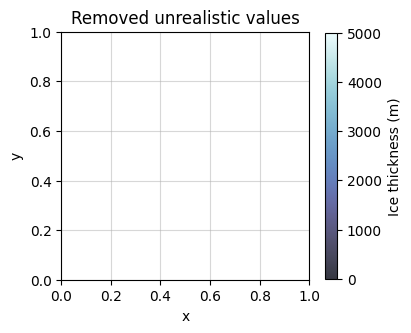

In [5]:
fig, ax = plt.subplots(figsize = (4, 4))

sc = ax.scatter(
    ice_ds_unrealistic[:, 0], 
    ice_ds_unrealistic[:, 1], 
    c = ice_ds_unrealistic[:, 2], 
    s = 1.5, 
    alpha = 0.8, 
    cmap = cmocean.cm.ice,
    vmin = 0, vmax = 5000
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel("x")
ax.set_ylabel("y")

ax.set_aspect('equal')
# grid for orientation
ax.grid(True, alpha = 0.5)

# Add colorbar
cbar = fig.colorbar(sc, ax = ax, shrink = 0.8)
cbar.set_label("Ice thickness (m)")

plt.title("Removed unrealistic values")
plt.show()

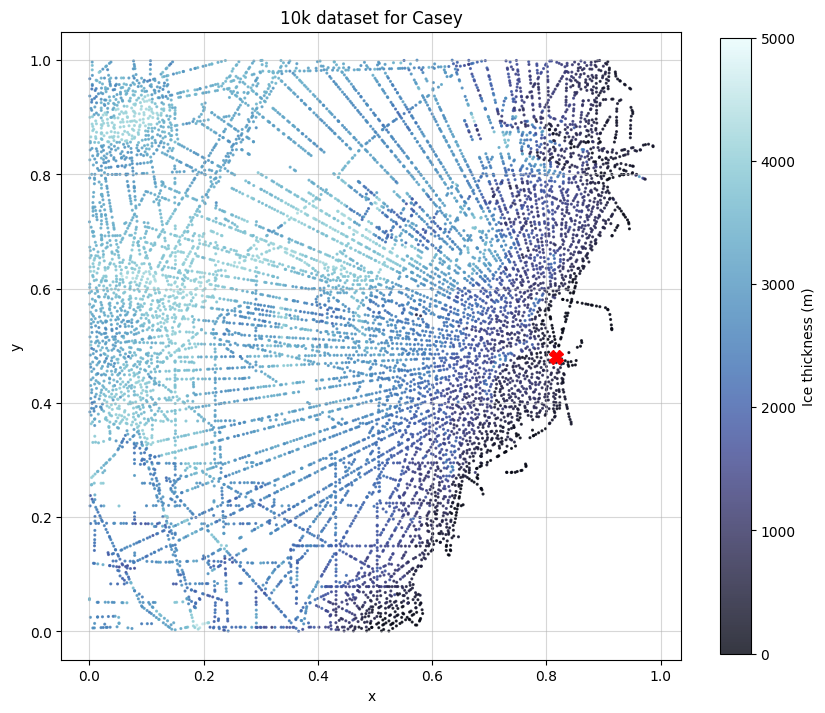

In [6]:
fig, ax = plt.subplots(figsize = (10, 10))

ice_ds_vis = ice_ds.detach().cpu()

sc = ax.scatter(
    ice_ds_vis[:, 0], 
    ice_ds_vis[:, 1], 
    c = ice_ds_vis[:, 2], 
    s = 1.5, 
    alpha = 0.8, 
    cmap = cmocean.cm.ice,
    vmin = 0, vmax = 5000
)

# Mark skiway location with red X
ax.plot(
    skiway_x_norm, 
    skiway_y_norm, 
    "rX", 
    markersize = 10, 
    label = "Casey skiway")

ax.set_xlabel("x")
ax.set_ylabel("y")

ax.set_aspect('equal')
# grid for orientation
ax.grid(True, alpha = 0.5)

# Add colorbar
cbar = fig.colorbar(sc, ax = ax, shrink = 0.8)
cbar.set_label("Ice thickness (m)")

plt.title("10k dataset for Casey")
plt.show()

# Look at data distribution

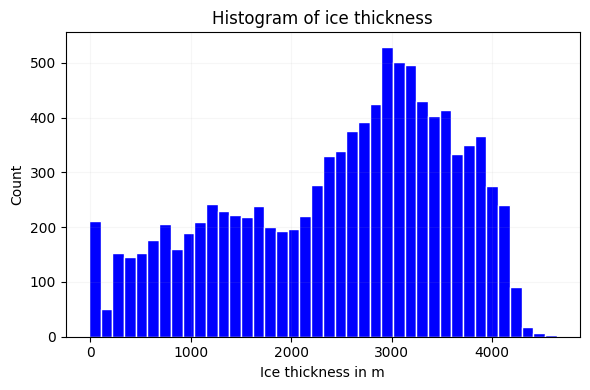

In [7]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.hist(ice_ds_vis[:, 2], bins = 40, edgecolor = 'white', color = "blue")
ax.set_xlabel('Ice thickness in m')                  
ax.set_ylabel('Count')
ax.set_title('Histogram of ice thickness')
ax.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

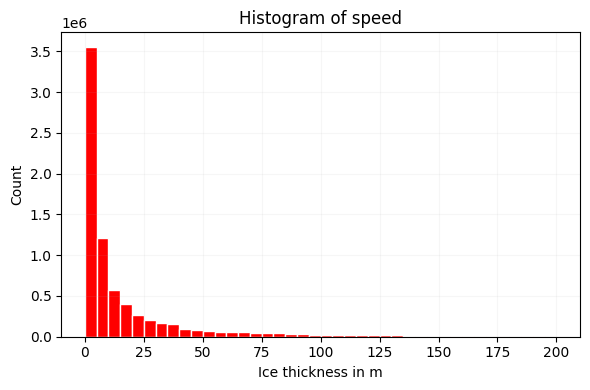

In [8]:
fig, ax = plt.subplots(figsize = (6, 4))
# NOTE: restrict range
ax.hist(speed_grid[-1, :, :].view(-1), bins = 40, edgecolor = 'white', color = "red", range = (0, 200))
ax.set_xlabel('Ice thickness in m')                  
ax.set_ylabel('Count')
ax.set_title('Histogram of speed')
ax.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

## Normalise ice thickness

In [9]:
ice_ds_norm = ice_ds[:, 2] / 1100

print(ice_ds_norm.std())
print(ice_ds_norm.var())

tensor(1.0128, device='cuda:0')
tensor(1.0259, device='cuda:0')


# Fit GP

In [10]:
gp = SingleTaskGP(
    # X: locations (already normalised to [0, 1])
    train_X = ice_ds[:, 0:2],
    # Y: thickness, unsqueeze to retain explicit dimension
    # normalise manually
    train_Y = ice_ds[:, 2].unsqueeze(-1) / 1100,
)

mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Optimises the GP hyperparameters and saves it
# Matern(ν = 2.5) kernel with ARD by default
# NOTE: 17 mins for 10k points on CPU
# NOTE: 3 mins for 10k points on GPU
fit_gpytorch_mll(mll)
# GPU memory

/tmp/ipykernel_7181/3717042892.py:1: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(
/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: Numer

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

In [11]:
# --- hyperparameters in the model space (NOTE: usually standardized) ---
const_mean = gp.mean_module.constant.detach().cpu().squeeze()
noise_var  = gp.likelihood.noise.detach().cpu().squeeze()  
lengthscales = gp.covar_module.lengthscale.detach().cpu() 

print(f"constant mean = {const_mean.item():.4g}")
print(f"noise var = {noise_var.item():.4g}")
print(f"lengthscales = {lengthscales.view(-1).tolist()}")

# Multiply by 1400 to get lengthscale in km
# In relation to the data density this should still be reasonable
print(f"lengthscale in km = {lengthscales * 1400}")

constant mean = -0.0008181
noise var = 0.03225
lengthscales = [0.02500000037252903, 0.02518555335700512]
lengthscale in km = tensor([[35.0000, 35.2598]])


## Candidate locations for AQF vis

In [29]:
# domain is 0 to 1
N_side = 90
# N_side**2 candidate points
side = torch.linspace(0, 1, N_side)
x, y = torch.meshgrid(side, side, indexing = 'xy')
X_points_long = torch.stack([x.flatten(), y.flatten()], dim = -1)
# batch_shape × q × d with q = 1: pointswise 
X_candidates = X_points_long.unsqueeze(1)

# Load mask of NaN values in speed grid
mask_na_tensor = torch.load("data/mask_na_casey_90_90.pt")

/tmp/ipykernel_7181/1347332599.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mask_na_tensor = torch.load("data/mask_na_casey_90_90.pt")


# Initialise UBC aquisition function

$
\begin{equation}
\alpha_{\mathrm{UCB}}(\mathbf{x}) = 
\mu(\mathbf{x}) + \sqrt{\beta_t}\,\sigma(\mathbf{x}),
\label{eq:ucb}
\end{equation}
$

In [39]:
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(
    model = gp,
    # beta controls the trade-off between exploration and exploitation via UCB = mu + beta * sigma
    # hence depends on data scaling
    # higher beta -> more exploration i.e. focus on data gaps
    beta = 100.0
)

UCB_mean_only = UpperConfidenceBound(
    model = gp,
    # UCB = mu 
    beta = 0.0
)

In [30]:
acq_values_UCB_mean_only = UCB_mean_only(X_candidates)
acq_values_UCB_mean_only_2d = acq_values_UCB_mean_only.reshape(N_side, N_side).detach().numpy()
acq_values_UCB_mean_only_2d[mask_na_tensor] = np.nan

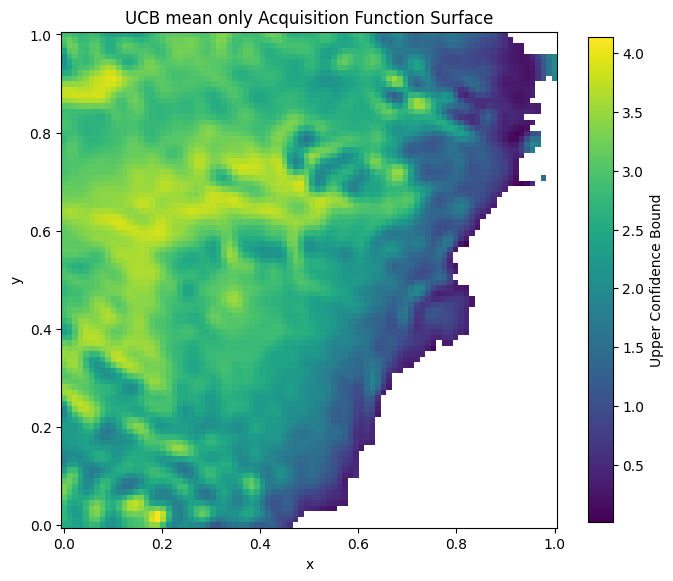

In [31]:
### VISUALISE ###
fig, ax = plt.subplots(figsize = (8, 7))

pcm = ax.pcolormesh(
    side, side, acq_values_UCB_mean_only_2d,
    shading = 'auto',
    cmap = "viridis", # "YlOrRd"
    # vmin = 0, vmax = 5
)

fig.colorbar(pcm, ax = ax, shrink = 0.9, label = "Upper Confidence Bound")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', adjustable = 'box')
ax.set_title("UCB mean only Acquisition Function Surface")
# Range is 0 to 4
plt.show()

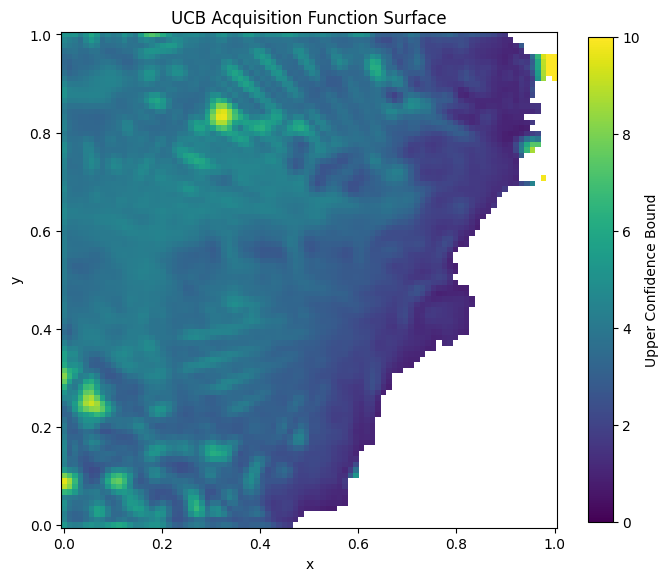

In [40]:
acq_values_UCB = UCB(X_candidates)
acq_values_UCB_2d = acq_values_UCB.reshape(N_side, N_side).detach().numpy()
acq_values_UCB_2d[mask_na_tensor] = np.nan

### VISUALISE ###
fig, ax = plt.subplots(figsize = (8, 7))

pcm = ax.pcolormesh(
    side, side, acq_values_UCB_2d,
    shading = 'auto',
    cmap = "viridis", # "YlOrRd"
    vmin = 0, vmax = 10
)

# show lengthscale elipsoid in bottom right corner
center = (0.9, 0.1)

ell = Ellipse(
    xy = center,
    # lengthscale is torch.Size([1, 2])
    width = 1 * float(lengthscales[0, 0]),
    height = 1 * float(lengthscales[0, 1]),
    angle = 0,
    edgecolor = 'red',
    facecolor = 'none',
    lw = 1,
)
# ax.add_patch(ell)

fig.colorbar(pcm, ax = ax, shrink = 0.9, label = "Upper Confidence Bound")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', adjustable = 'box')
ax.set_title("UCB Acquisition Function Surface")

plt.show()

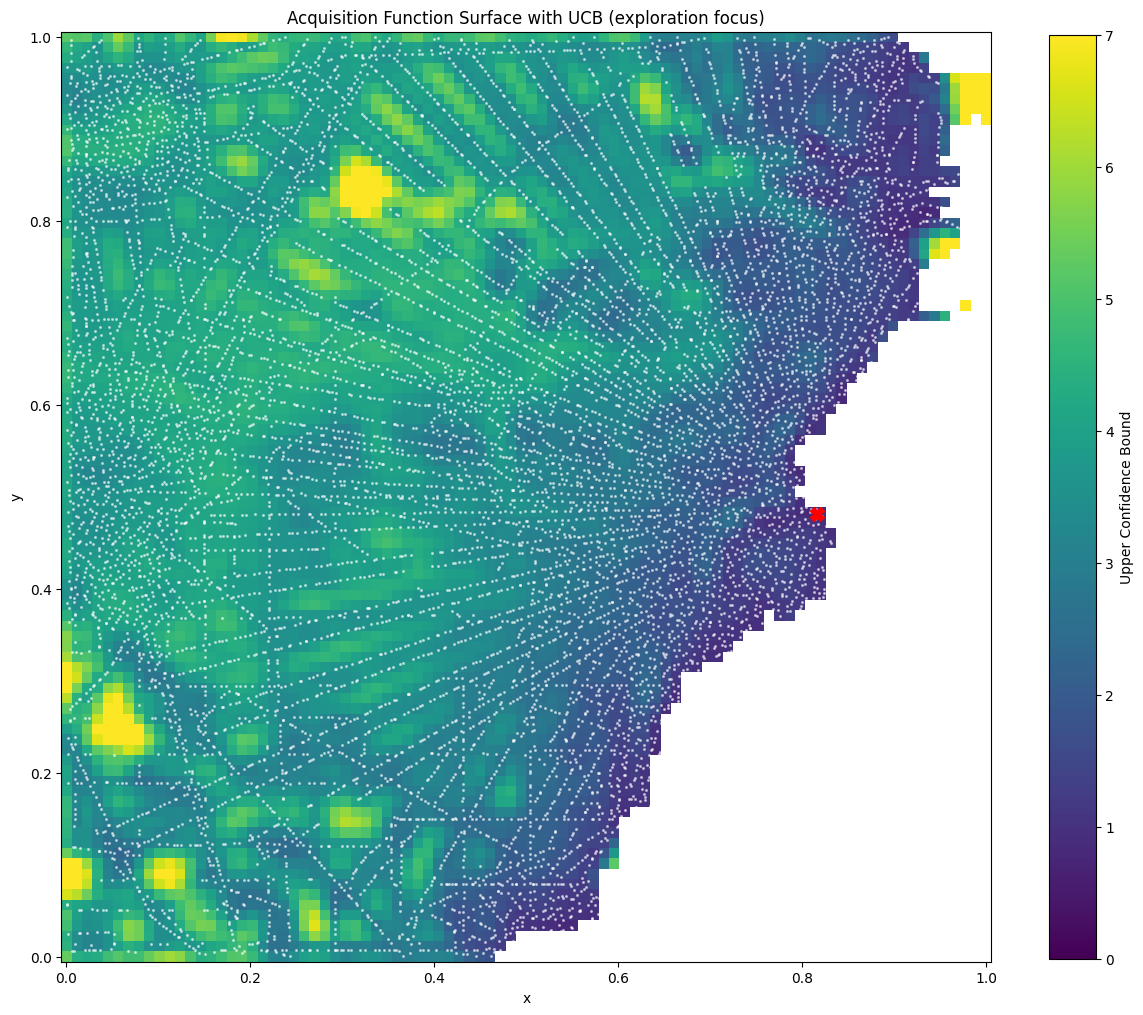

In [42]:
plt.figure(figsize = (15, 15))

pc = plt.pcolormesh(
    side, side, acq_values_UCB_2d,
    shading = 'auto',
    cmap = 'viridis',
    vmin = 0, vmax = 7
)

plt.scatter(
    ice_ds_vis[:, 0], 
    ice_ds_vis[:, 1], 
    c = "white",
    s = 1.5, 
    alpha = 0.5
)

# Mark skiway location with red X
plt.plot(
    skiway_x_norm, 
    skiway_y_norm, 
    "rX", 
    markersize = 10, 
    label = "Casey skiway"
)

# Attach colorbar only to pcolormesh
plt.colorbar(pc, label = "Upper Confidence Bound", shrink = 0.8)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Acquisition Function Surface with UCB (exploration focus)")
plt.gca().set_aspect('equal', adjustable = 'box')

plt.savefig("figures/acq_surface_UCB.png", dpi = 600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Custom Aquisition function

See https://botorch.org/docs/tutorials/custom_acquisition/

Difference if we want to use q-functions or regular aquisition functions

Names:
- Physically Guided UCB (PG-UCB)
- Weighted UCB (WUCB)
- Spatially Weighted UCB

related to "Robust prior-biased acquisition function for human-in-the-loop Bayesian optimization"

In [43]:
device = "cpu"
speed_grid = speed_grid.to(device)

# Discount weight for flow flow areas
def sigmoid_through_points(w, low_speed_discount, speed_low = 0.0, weight_low = 0.5, speed_high = 100.0, weight_high = 1.0):
    """
    Map w -> (0,1) with a sigmoid so that f(speed_low) = weight_low and f(speed_high) = weight_high.
    Defaults give ~0.2 at 0 and ~0.99 by 100.
    """
    # If discount is 0.7 for low speeds, then weight at low speed is 0.3 (compared to 1 at high speeds)
    weight_low = 1 - low_speed_discount

    # guard probs into (0,1)
    eps = 1e-6
    weight_low = float(min(max(weight_low, eps), 1 - eps))
    weight_high = float(min(max(weight_high, eps), 1 - eps))

    def logit(p): return math.log(p / (1 - p))
    a = (logit(weight_high) - logit(weight_low)) / (speed_high - speed_low)
    b = logit(weight_low) - a * speed_low
    return torch.sigmoid(a * w + b)

class WeightedUCB(AnalyticAcquisitionFunction):
    """
    We are weighting UCB by the flux.
    UCB(X) * weight(X), where weight is bilinearly interpolated from a raster field.
    UCB = mu + sqrt(beta * sigma^2). Works with q=1 and batched evaluation.
    """
    def __init__(self, model: Model, beta: float = 2.0, low_speed_discount: float = 0.7):
        super().__init__(model = model)
        self.beta = beta
        self.low_speed_discount = low_speed_discount
        # self.field = field_module

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X: batch_shape x q x d  (q must be 1 for analytic UCB)

        X = X.to(device)
        self.model = self.model.to(device)

        # print("X_candidates device:", X.device)
        # print("Model param device:", next(gp.parameters()).device)
        # print("Train inputs device:", gp.train_inputs[0].device)
        # print("Train targets device:", gp.train_targets.device)

        # device issue
        posterior = self.model.posterior(X)
        mean = posterior.mean.squeeze(-1)          # -> batch_shape x q
        var  = posterior.variance.squeeze(-1)      # -> batch_shape x q
        ucb  = mean + torch.sqrt(self.beta * var)  # -> batch_shape x q

        print("UCB max:", ucb.device)

        # Interpolated weights from field
        # w = self.field(X)                          # -> batch_shape x q

        # X is shape (N_long, q = 1, 2)
        # X_dense
        X_dense = X.view(-1, 2)

        X_ps = norm_to_ps(X_dense)
        X_for_interpolation = ps_to_speed(X_ps).to(device) # -> (batch_shape * q), 2

        speed = torch.nn.functional.grid_sample(
            # the source grid (regular grid) is the input
            # [N, C, H, W]
            input = speed_grid[-1, :, :].unsqueeze(0).unsqueeze(0),
            # the target (irregular) grid (points) is the query
            # [N, q (H), W, 2] q number of queries
            grid = X_for_interpolation.unsqueeze(0).unsqueeze(2), 
            mode = 'bilinear', 
            align_corners = True).to(device)
        
        # Remove first two singleton dimensions
        w = sigmoid_through_points(speed.squeeze(0).squeeze(0), self.low_speed_discount).to(device)
        print(w.max())
        
        # Multiply and reduce q dimension (q = 1)
        return (ucb * w).squeeze(-1)               # -> batch_shape
    
WUCB = WeightedUCB(
    model = gp,
    # beta controls the trade-off between exploration and exploitation via UCB = mu + beta * sigma
    # hence depends on data scaling
    # higher beta -> more exploration i.e. focus on data gaps
    beta = 2.0,
    # low speed discount for flow areas
    low_speed_discount = 0.7 
)

In [28]:
mask_na = np.isnan(acq_values_WUCB_2d)

# Convert to torch tensor
mask_na_tensor = torch.tensor(mask_na)

# Save as .pt file
torch.save(mask_na_tensor, "data/mask_na_casey_90_90.pt")

UCB max: cpu
tensor(nan)


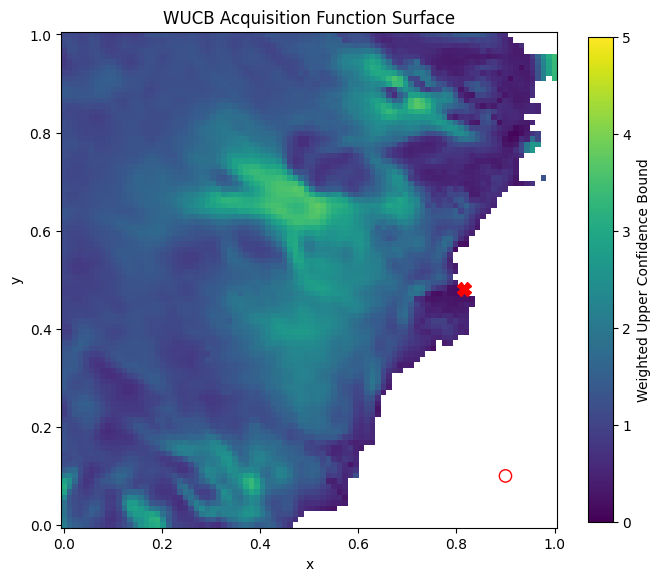

In [44]:
acq_values_WUCB = WUCB(X_candidates)
acq_values_WUCB_2d = acq_values_WUCB.reshape(N_side, N_side).detach().numpy()

### PLOT ###
fig, ax = plt.subplots(figsize = (8, 7))

pcm = ax.pcolormesh(
    side, side, acq_values_WUCB_2d,
    shading = 'auto',
    cmap = "viridis", # "YlOrRd"
    vmin = 0, vmax = 5
)

# show lengthscale elipsoid in bottom right corner
center = (0.9, 0.1)
ell = Ellipse(
    xy = center,
    # lengthscale is torch.Size([1, 2])
    width = 1 * float(lengthscales[0, 0]),
    height = 1 * float(lengthscales[0, 1]),
    angle = 0,
    edgecolor = 'red',
    facecolor = 'none',
    lw = 1,
)
ax.add_patch(ell)

# Mark skiway location with red X
ax.plot(
    skiway_x_norm, 
    skiway_y_norm, 
    "rX", 
    markersize = 10, 
    label = "Casey skiway")

fig.colorbar(pcm, ax = ax, shrink = 0.9, label = "Weighted Upper Confidence Bound")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', adjustable = 'box')
ax.set_title("WUCB Acquisition Function Surface")

plt.show()

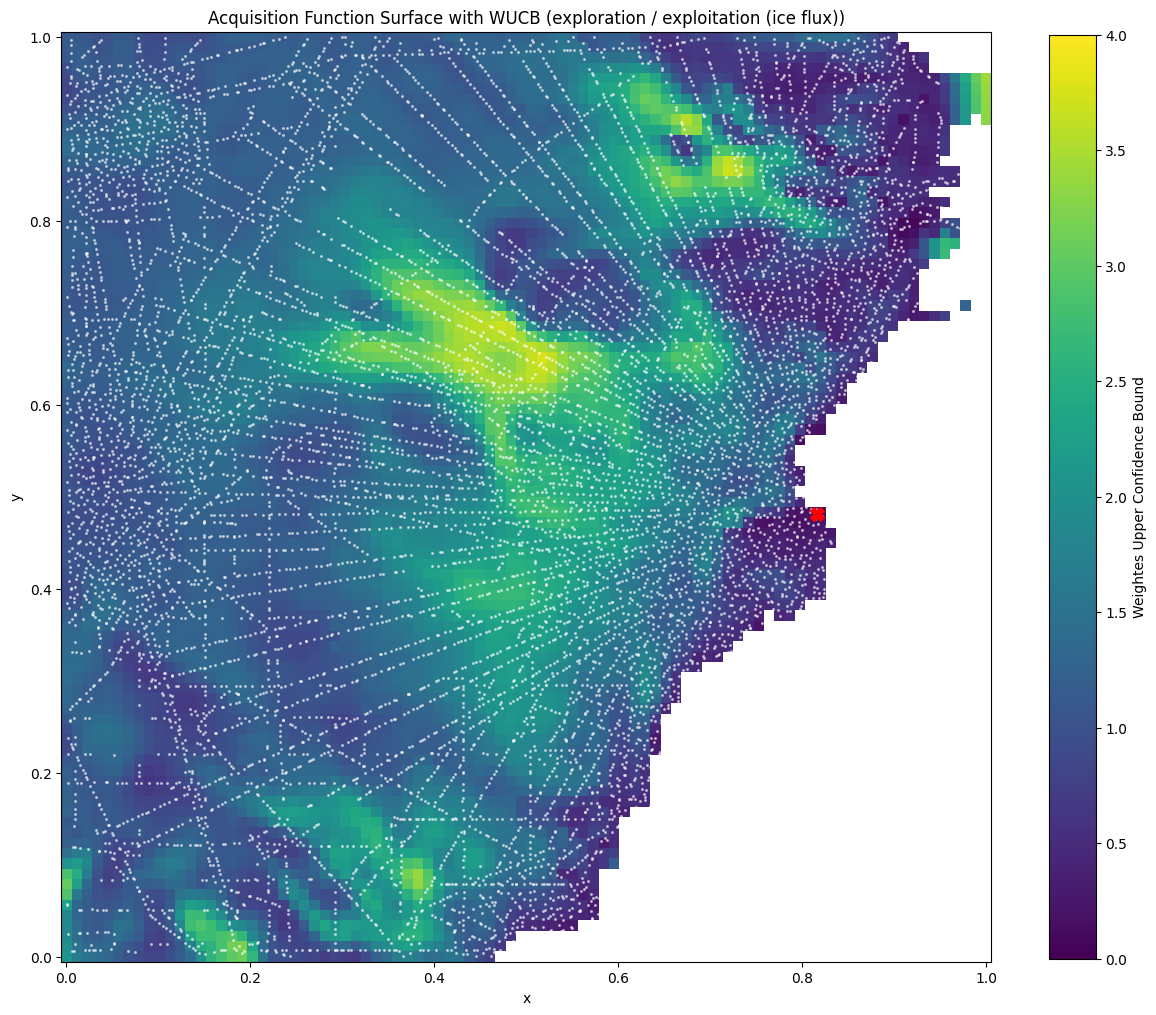

In [45]:
plt.figure(figsize = (15, 15))

pc = plt.pcolormesh(
    side, side, acq_values_WUCB_2d,
    shading = 'auto',
    cmap = 'viridis',
    vmin = 0, vmax = 4
)

plt.scatter(
    ice_ds_vis[:, 0], 
    ice_ds_vis[:, 1], 
    c = "white",
    s = 1.5, 
    alpha = 0.5
)

# Mark skiway location with red X
plt.plot(
    skiway_x_norm, 
    skiway_y_norm, 
    "rX", 
    markersize = 10, 
    label = "Casey skiway"
)

# Attach colorbar only to pcolormesh
plt.colorbar(pc, label = "Weightes Upper Confidence Bound", shrink = 0.8)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Acquisition Function Surface with WUCB (exploration / exploitation (ice flux))")
plt.gca().set_aspect('equal', adjustable = 'box')

plt.savefig("figures/acq_surface_WUCB.png", dpi = 600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

In [ ]:
plt.figure(figsize = (15, 15))
plt.pcolormesh(side, side, acq_values_UCB_2d, shading = 'auto', cmap = 'viridis')

# REDUCE_RATE = 1 (all 8M -> Takes 2 minutes to render)
REDUCE_RATE = 1 
plt.scatter(
    ice[:, 0][::REDUCE_RATE], 
    ice[:, 1][::REDUCE_RATE], 
    c = "white", # "white", ice[:, 2]
    s = 1.5, alpha = 0.8, cmap = 'Oranges') # 'BuPu'

plt.colorbar(label = "Weighted UCB")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Acquisition Function Surface")
plt.gca().set_aspect('equal', adjustable = 'box')

plt.savefig("figures/acq_surface_UCB_all_data.png", dpi = 600, bbox_inches=  'tight', pad_inches = 0.02)
plt.show()

# Next point

In [ ]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)]).to(torch.double)

candidate, acq_value = optimize_acqf(
    WUCB, # UBC
    bounds = bounds, 
    # Get batch of points, chosen jointly: Batch BO
    q = 1, 
    num_restarts = 5, 
    raw_samples = 5,
)

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    ice[:, 0][::REDUCE_RATE], 
    ice[:, 1][::REDUCE_RATE], 
    c = ice[:, 2][::REDUCE_RATE], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

ax.plot(
    candidate[:, 0], 
    candidate[:, 1], 
    color = "magenta", 
    marker = "o", 
    markersize = 8, 
    linestyle = "None",
    label = "Candidate")

ax.plot(skiway_x_norm, skiway_y_norm, "ro", markersize = 8, label = "Casey skiway")

# Optional: label axes to clarify units
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Bounds

- discrete sec of points
- add term over water?

from botorch.optim.optimize import optimize_acqf_discrete
import torch

# 1) Generate candidate pool in a box
pool = torch.rand(2000, 2) * (ub - lb) + lb  # (N, d)

# 2) Keep only feasible points
feasible = pool[mask_bool(pool)]             # implement mask_bool with your polygon / raster mask

# 3) Maximise over discrete set
cand, acq = optimize_acqf_discrete(
    acq_function=logNEI,
    choices=feasible.unsqueeze(1),  # (N, q=1, d)
    q=1,
)

## Batch BO

Not compatible withh all aquisition functions

In [ ]:
NUM_BATCH = 20
from botorch.acquisition.monte_carlo import qExpectedImprovement

qEI = qExpectedImprovement(model = gp, best_f = ice_reduced[:, 2].max())

candidates, acq_values = optimize_acqf(
    acq_function = qEI,
    bounds = bounds,
    # Batch
    q = NUM_BATCH,
    num_restarts = 10,
    raw_samples = 128,
)

print(candidates.shape)

In [ ]:
CONNECT_LINES = True
if CONNECT_LINES:
    # Add skiway as start and end point
    candidates = torch.concat((skiway, candidates, skiway), dim = 0)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    ice_reduced[:, 0], 
    ice_reduced[:, 1], 
    c = ice_reduced[:, 2], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

ax.plot(
    candidates[:, 0], 
    candidates[:, 1], 
    color = "magenta", 
    marker = "o", 
    markersize = 8, 
    linestyle = "solid" if CONNECT_LINES else "None",  # <- disables line
    label = "Candidate")

ax.plot(skiway_x_norm, skiway_y_norm, "ro", markersize = 8, label = "Casey skiway")

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Show aquisition function

In [ ]:
import torch
import matplotlib.pyplot as plt

# --- 2. Make a grid over [0,1]^2 (assuming you've normalised inputs) ---
grid_size = 100
x1 = torch.linspace(0, 1, grid_size)
x2 = torch.linspace(0, 1, grid_size)
X1, X2 = torch.meshgrid(x1, x2, indexing = "ij")
grid = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

# --- 3. Evaluate acquisition function ---
with torch.no_grad():
    acq_values = qEI(grid.unsqueeze(1))  # shape [N, 1]
acq_values = acq_values.view(grid_size, grid_size).cpu()

# --- 4. Plot ---
plt.figure(figsize=(6,5))
pcm = plt.pcolormesh(x1, x2, acq_values.T, shading = "auto", cmap = "jet")
plt.colorbar(pcm, label = "qEI")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("qEI Acquisition Landscape")
plt.show()

# ToDo:

- bounds: ice sheet only
    - With accept/reject
    - constraint https://archive.botorch.org/v/0.9.2/api/_modules/botorch/optim/parameter_constraints.html
- new aquisition function
- EI function: outlier in data? so focused function